<a href="https://colab.research.google.com/github/ByeongKyuPark/ByeongKyuPark.github.io/blob/main/CS445_Proj2_Starter_(1)_grok3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time

datadir = "/content/drive/MyDrive/Colab Notebooks/CS445 Computational Photography/2_Project_Image_Quilting/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [50]:
from utils import cut # default cut function for seam finding section

### Utils

In [51]:
def random_patch(sample, patch_size):
    # extract a random patch from sample of size patch_size x patch_size.
    H, W, C = sample.shape
    i = random.randint(0, H - patch_size)
    j = random.randint(0, W - patch_size)
    return sample[i:i+patch_size, j:j+patch_size]

def ssd_patch(sample, template, mask):
    # SSD between template (from the output) <-> all possible patches in the sample(e.g., texture)
    # SSD = ∑ [ (T•M-S•M) **2] = ∑[ ((T-S)•M) **2] = ∑ (T^2-2TS+S^2)•M
		# 										 = ∑ M•T^2 -2∑(M•T)S + ∑(M•S^2)
		# 										 # M=M^2 for binary M(either 0 or 1)
		# 										 = ∑ (M•T)^2 -2∑(M•T)S + ∑(M•S^2)
		# => ((M*T)**2).sum() - 2*cv2.filter2D(S,kernel = M*T) + cv2.filter2D(S ** 2, kernel=M).

    # for precisions
    template = template.astype(np.float32) # e.g., (3x3)
    sample = sample.astype(np.float32)     # e.g., (5x5)
    mask = mask.astype(np.float32)         # e.g., (3x3)

    s_h, s_w = sample.shape[0], sample.shape[1]
    t_h, t_w = template.shape[0], template.shape[1]

    kernel_h = s_h - t_h + 1 # 5-3+1 = 3
    kernel_w = s_w - t_w + 1 # 5-3+1 = 3

    # 3x3
    ssd_cost = np.zeros((kernel_h, kernel_w), dtype=np.float32)

    # see the comments below
    padding_h, padding_w = (t_h - 1) // 2, (t_w - 1) // 2

    for channel in range(sample.shape[2]):
        M = mask
        T = template[:, :, channel]
        S = sample[:, :, channel]

        # 'cv2.filter2D' internally adds padding for edge computations
        # e.g., for sample[0,0], it pads to include kernel data outside 5x5
        filtered_S = cv2.filter2D(S, -1, M * T)
        filtered_S2 = cv2.filter2D(S ** 2, -1, M)

        # therefore, we trim padded edges to get valid 3x3 cost
        valid_filtered_S = filtered_S[padding_h:padding_h + kernel_h, padding_w:padding_w + kernel_w]
        valid_filtered_S2 = filtered_S2[padding_h:padding_h + kernel_h, padding_w:padding_w + kernel_w]

        ssd_cost += ((M * T) ** 2).sum() - 2 * valid_filtered_S + valid_filtered_S2

    return ssd_cost

def choose_sample(ssd_cost, tol):
    # flatten the cost array
    cols = ssd_cost.shape[1]
    ssd_cost = ssd_cost.flatten()

    # get indices of ascending orders
    sorted_indices = np.argsort(ssd_cost)

    # select one randomly from the top 'tol' cheapest candidates
    selected_index = sorted_indices[random.randint(0, min(tol - 1, len(sorted_indices) - 1))]

    # to 2D again
    return  selected_index // cols , selected_index % cols

### Part I: Randomly Sampled Texture (10 pts)

In [52]:
def quilt_random(sample, out_size, patch_size): # (192,192,3), 200, 15
    """
    I. Naive Random Patch Quilting
        Randomly picks patches from the sample texture and places them into the output image.
    """
    H, W, C = sample.shape # 192, 192, 3
    print(f'sample size = {H}, {W}, {C}')
    num_patches = int(np.ceil(out_size / patch_size)) # 200/15 = 13.~ -> 14
    print(f'{num_patches} patches') # 14 patches

    # an imaginary canvas for the output (slightly bigger than the output)
    out_canvas_width = num_patches * patch_size # 210
    print(f'{out_canvas_width} output canvas size') # larger than out_size
    out_canvas = np.zeros((out_canvas_width, out_canvas_width, C), dtype=sample.dtype) # 210 X 210

    for i in range(num_patches):
        for j in range(num_patches):
            patch = random_patch(sample, patch_size)
            out_canvas[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    # crop the output image to exactly out_size x out_size.
    print(f'output canvas (before clamping) : {out_canvas.shape}') # larger than out_size
    # clamp the canvas to fit into the out size
    return out_canvas[:out_size, :out_size, :]


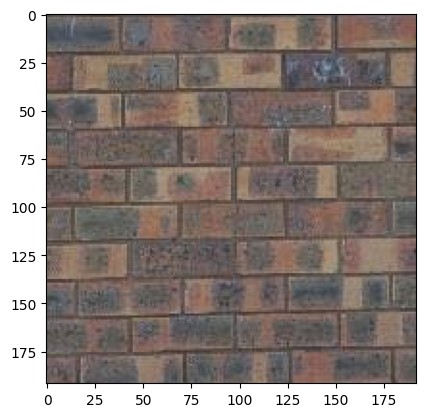

sample size = 192, 192, 3
5 patches
225 output canvas size
output canvas (before clamping) : (225, 225, 3)


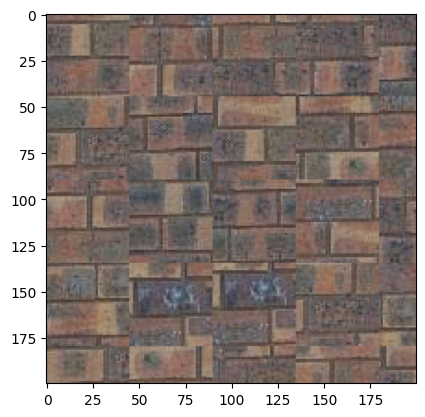

In [53]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 45
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [54]:
# def ssd_patch(sample, template, mask):
#     # Ensure float32 for computation
#     template = template.astype(np.float32)
#     sample = sample.astype(np.float32)
#     mask = mask.astype(np.float32)

#     # Dimensions
#     H, W = sample.shape[0], sample.shape[1]  # e.g., 192, 192
#     k_h, k_w = template.shape[0], template.shape[1]  # e.g., 70, 70
#     valid_h = H - k_h + 1  # 123
#     valid_w = W - k_w + 1  # 123
#     channels = sample.shape[2]

#     # Initialize ssd_cost
#     ssd_cost = np.zeros((valid_h, valid_w), dtype=np.float32)

#     # Compute padding for cropping
#     pad_h = (k_h - 1) // 2  # 34
#     pad_w = (k_w - 1) // 2  # 34

#     for c in range(channels):
#         M = mask  # (70, 70)
#         T = template[:, :, c]  # (70, 70)
#         I = sample[:, :, c]  # (192, 192)

#         # Perform filtering
#         filtered_I = cv2.filter2D(I, -1, M * T)  # (192, 192)
#         filtered_I2 = cv2.filter2D(I ** 2, -1, M)  # (192, 192)

#         # Extract valid regions
#         valid_filtered_I = filtered_I[pad_h:pad_h + valid_h, pad_w:pad_w + valid_w]  # (123, 123)
#         valid_filtered_I2 = filtered_I2[pad_h:pad_h + valid_h, pad_w:pad_w + valid_w]  # (123, 123)

#         # Compute SSD contribution for this channel
#         ssd_cost += ((M * T) ** 2).sum() - 2 * valid_filtered_I + valid_filtered_I2

#     return ssd_cost

# def choose_sample(ssd_cost, tol):
#     """
#     Choose a patch position based on SSD cost.

#     Parameters:
#     - ssd_cost (numpy.ndarray): SSD cost for each possible patch.
#     - tol (int): Number of lowest-cost patches to consider.

#     Returns:
#     - tuple: (y, x) coordinates of the chosen patch in the sample.
#     """
#     # Flatten the cost array
#     flat_cost = ssd_cost.flatten()

#     # Get indices of sorted costs (ascending order)
#     sorted_indices = np.argsort(flat_cost)

#     # Select a random index from the top 'tol' lowest costs
#     selected_index = sorted_indices[random.randint(0, min(tol - 1, len(sorted_indices) - 1))]

#     # Convert flat index to 2D coordinates
#     y = selected_index // ssd_cost.shape[1]
#     x = selected_index % ssd_cost.shape[1]
#     return y, x

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patch_size from sample to create an output image of size out_size,
    ensuring the entire output is filled without black borders.

    Parameters:
    - sample (numpy.ndarray): Input sample image (H x W x C).
    - out_size (int): Size of the square output image (out_size x out_size).
    - patch_size (int): Size of each square patch (patch_size x patch_size).
    - overlap (int): Number of overlapping pixels between adjacent patches.
    - tol (float): Tolerance factor for selecting patches (1 = lowest cost, >1 = random from top tol lowest costs).

    Returns:
    - numpy.ndarray: Synthesized output image.
    """
    # Convert sample to float32 for computations
    sample = np.array(sample, dtype=np.float32)

    # Initialize output image with zeros (out_size x out_size x channels)
    out = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.float32)

    # Calculate step size (non-overlapping distance between patch starts)
    step = patch_size - overlap

    # Calculate the number of patches needed to cover the output, ensuring full coverage
    num_patches_x = ((out_size - 1) // step) + 1  # Ensure we cover the full width
    num_patches_y = ((out_size - 1) // step) + 1  # Ensure we cover the full height

    # Iterate over the grid of patch positions
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            # Calculate starting coordinates, adjusting for edges to ensure coverage
            start_i = min(i * step, out_size - patch_size)  # Ensure patch fits within bounds
            start_j = min(j * step, out_size - patch_size)  # Ensure patch fits within bounds

            # Handle the first patch (top-left corner)
            if i == 0 and j == 0:
                # Randomly select a patch from the sample
                rand_y = random.randint(0, sample.shape[0] - patch_size)
                rand_x = random.randint(0, sample.shape[1] - patch_size)
                patch = sample[rand_y:rand_y + patch_size, rand_x:rand_x + patch_size]
                out[start_i:start_i + patch_size, start_j:start_j + patch_size] = patch
            else:
                # Determine overlapping regions
                overlap_left = j > 0
                overlap_top = i > 0

                # Create a mask for overlapping regions
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if overlap_left:
                    mask[:, :overlap] = 1
                if overlap_top:
                    mask[:overlap, :] = 1

                # Extract the template from the current output (overlapping area)
                template = out[start_i:start_i + patch_size, start_j:start_j + patch_size].copy()
                template *= mask[..., np.newaxis]

                # Compute SSD cost for all possible patches
                ssd_cost = ssd_patch(sample, template, mask)

                # Choose a patch with low SSD cost
                patch_y, patch_x = choose_sample(ssd_cost, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # Copy the selected patch to the output
                out[start_i:start_i + patch_size, start_j:start_j + patch_size] = patch

    # Clip values to valid pixel range and convert to uint8
    return np.clip(out, 0, 255).astype(np.uint8)

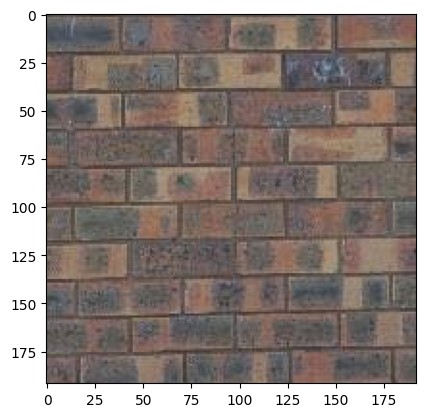

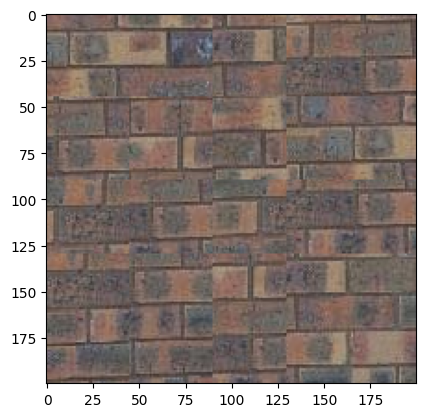

In [55]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  #300 change these parameters as needed (was 300)
patch_size = 70 # 25
overlap = 25 # 11
tol = 15
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    # plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [56]:
import numpy as np
import cv2
import random
from utils import cut  # Importing the cut function from the utility module

def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patch_size from sample using seam finding to create an output image of size out_size.

    Parameters:
    - sample (numpy.ndarray): Input sample image (H x W x C).
    - out_size (int): Size of the square output image (out_size x out_size).
    - patch_size (int): Size of each square patch (patch_size x patch_size).
    - overlap (int): Number of overlapping pixels between adjacent patches.
    - tol (float): Tolerance factor for selecting patches (1 = lowest cost, >1 = random from top tol lowest costs).

    Returns:
    - numpy.ndarray: Synthesized output image of shape (out_size, out_size, C) with dtype uint8.
    """
    # Convert sample to float32 for computations
    sample = np.array(sample, dtype=np.float32)

    # Initialize output image with zeros
    out = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.float32)

    # Calculate step size and number of patches to cover the output
    step = patch_size - overlap
    num_patches_x = ((out_size - 1) // step) + 1
    num_patches_y = ((out_size - 1) // step) + 1

    # Iterate over patch positions
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            # Calculate starting coordinates, ensuring patches fit within bounds
            start_i = min(i * step, out_size - patch_size)
            start_j = min(j * step, out_size - patch_size)

            if i == 0 and j == 0:
                # First patch: randomly select and copy directly
                rand_y = random.randint(0, sample.shape[0] - patch_size)
                rand_x = random.randint(0, sample.shape[1] - patch_size)
                patch = sample[rand_y:rand_y + patch_size, rand_x:rand_x + patch_size]
                out[start_i:start_i + patch_size, start_j:start_j + patch_size] = patch
            else:
                # Determine overlapping regions
                overlap_left = j > 0
                overlap_top = i > 0

                # Create mask for SSD computation in overlapping regions
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if overlap_left:
                    mask[:, :overlap] = 1
                if overlap_top:
                    mask[:overlap, :] = 1

                # Extract template from current output for patch selection
                template = out[start_i:start_i + patch_size, start_j:start_j + patch_size].copy()

                # Compute SSD cost and select a patch
                ssd_cost = ssd_patch(sample, template, mask)
                patch_y, patch_x = choose_sample(ssd_cost, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # Initialize full mask for seam finding (1 means take from new patch)
                full_mask = np.ones((patch_size, patch_size), dtype=bool)

                # Handle left overlap
                if overlap_left:
                    existing_left = out[start_i:start_i + patch_size, start_j:start_j + overlap]
                    new_left = patch[:, :overlap]
                    err_patch_left = np.sum((existing_left - new_left) ** 2, axis=2)
                    left_seam_mask = cut(err_patch_left.T).T  # Transpose for vertical seam
                    full_mask[:, :overlap] = left_seam_mask

                # Handle top overlap
                if overlap_top:
                    existing_top = out[start_i:start_i + overlap, start_j:start_j + patch_size]
                    new_top = patch[:overlap, :]
                    err_patch_top = np.sum((existing_top - new_top) ** 2, axis=2)
                    top_seam_mask = cut(err_patch_top)
                    full_mask[:overlap, :] = top_seam_mask

                # Handle corner (both overlaps) by intersecting masks
                if overlap_left and overlap_top:
                    corner_left = left_seam_mask[:overlap, :overlap]
                    corner_top = top_seam_mask[:overlap, :overlap]
                    full_mask[:overlap, :overlap] = np.logical_and(corner_left, corner_top)

                # Apply the mask to blend the patch with the existing output
                out_patch = out[start_i:start_i + patch_size, start_j:start_j + patch_size]
                out[start_i:start_i + patch_size, start_j:start_j + patch_size] = np.where(
                    full_mask[..., np.newaxis], patch, out_patch)

    # Clip and convert to uint8
    return np.clip(out, 0, 255).astype(np.uint8)

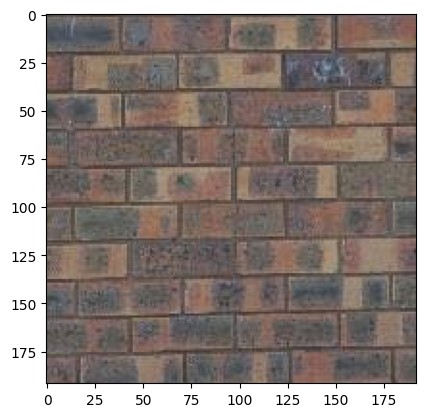

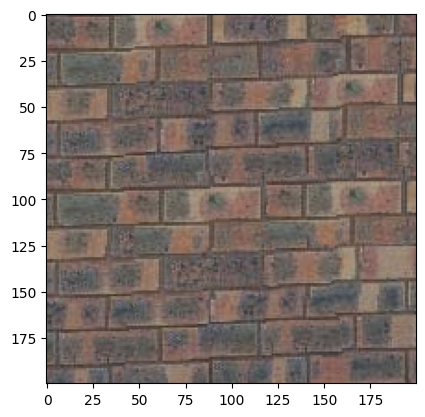

In [57]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # 300, change these parameters as needed
patch_size = 50 # 25
overlap = 11    # 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    #plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [58]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Texture transfer using seam-finding with the provided cut function.

    :param sample: numpy.ndarray, source texture image.
    :param patch_size: int, width/height of square patch.
    :param overlap: int, overlapping region width.
    :param tol: float, tolerance for candidate selection.
    :param guidance_im: numpy.ndarray, target guidance image.
    :param alpha: float (0-1), weight for guidance cost.
    :return: numpy.ndarray, synthesized texture.
    """
    # Convert images to float32 for computations
    sample = np.array(sample, dtype=np.float32)
    guidance_im = np.array(guidance_im, dtype=np.float32)

    # Determine output shape from guidance image
    out_height, out_width = guidance_im.shape[:2]
    out = np.zeros((out_height, out_width, sample.shape[2]), dtype=np.float32)

    # Calculate step size and number of patches
    step = patch_size - overlap
    num_patches_y = ((out_height - patch_size) // step) + 1
    num_patches_x = ((out_width - patch_size) // step) + 1

    for i in range(num_patches_y):
        for j in range(num_patches_x):
            # Calculate starting coordinates, ensuring patches fit within bounds
            start_i = min(i * step, out_height - patch_size)
            start_j = min(j * step, out_width - patch_size)

            if i == 0 and j == 0:
                # Randomly select first patch
                rand_y = random.randint(0, sample.shape[0] - patch_size)
                rand_x = random.randint(0, sample.shape[1] - patch_size)
                patch = sample[rand_y:rand_y + patch_size, rand_x:rand_x + patch_size]
                out[start_i:start_i + patch_size, start_j:start_j + patch_size] = patch
            else:
                # Determine overlapping regions
                overlap_left = j > 0
                overlap_top = i > 0

                # Create overlap mask
                overlap_mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if overlap_left:
                    overlap_mask[:, :overlap] = 1
                if overlap_top:
                    overlap_mask[:overlap, :] = 1

                # Extract template from current output for overlap SSD
                template = out[start_i:start_i + patch_size, start_j:start_j + patch_size].copy()

                # Compute overlap SSD
                overlap_ssd = ssd_patch(sample, template, overlap_mask)

                # Extract guidance patch
                guidance_patch = guidance_im[start_i:start_i + patch_size, start_j:start_j + patch_size]

                # Create guidance mask (all ones)
                guidance_mask = np.ones((patch_size, patch_size), dtype=np.float32)

                # Compute guidance SSD
                guidance_ssd = ssd_patch(sample, guidance_patch, guidance_mask)

                # Compute total cost
                total_cost = (1 - alpha) * overlap_ssd + alpha * guidance_ssd

                # Choose a patch with low total cost
                patch_y, patch_x = choose_sample(total_cost, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # Initialize full mask for seam finding
                full_mask = np.ones((patch_size, patch_size), dtype=bool)

                # Handle left overlap
                if overlap_left:
                    existing_left = out[start_i:start_i + patch_size, start_j:start_j + overlap]
                    new_left = patch[:, :overlap]
                    err_patch_left = np.sum((existing_left - new_left) ** 2, axis=2)
                    left_seam_mask = cut(err_patch_left.T).T  # Transpose for vertical seam
                    full_mask[:, :overlap] = left_seam_mask

                # Handle top overlap
                if overlap_top:
                    existing_top = out[start_i:start_i + overlap, start_j:start_j + patch_size]
                    new_top = patch[:overlap, :]
                    err_patch_top = np.sum((existing_top - new_top) ** 2, axis=2)
                    top_seam_mask = cut(err_patch_top)
                    full_mask[:overlap, :] = top_seam_mask

                # Handle corner (both overlaps) by intersecting masks
                if overlap_left and overlap_top:
                    corner_left = left_seam_mask[:overlap, :overlap]
                    corner_top = top_seam_mask[:overlap, :overlap]
                    full_mask[:overlap, :overlap] = np.logical_and(corner_left, corner_top)

                # Apply the mask to blend the patch
                out_patch = out[start_i:start_i + patch_size, start_j:start_j + patch_size]
                out[start_i:start_i + patch_size, start_j:start_j + patch_size] = np.where(
                    full_mask[..., np.newaxis], patch, out_patch)

    # Clip and convert to uint8
    return np.clip(out, 0, 255).astype(np.uint8)

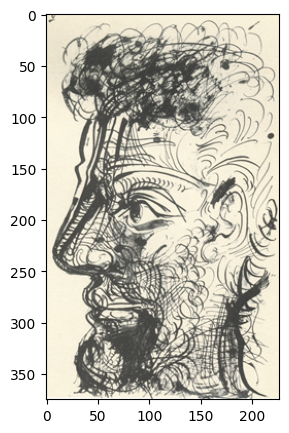

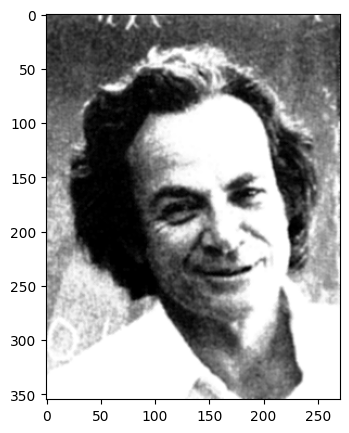

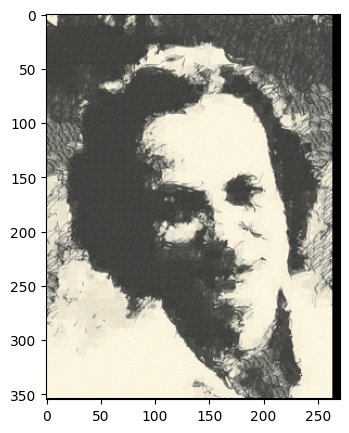

In [59]:
texture_img = cv2.cvtColor(cv2.imread('samples/sketch.tiff'), cv2.COLOR_BGR2RGB)
#texture_img = cv2.cvtColor(cv2.imread('samples/bricks_small.jpg'), cv2.COLOR_BGR2RGB)
#guidance_img = cv2.cvtColor(cv2.imread('samples/feynman.tiff'), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread('samples/feynman.tiff'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(texture_img)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(guidance_img)
plt.show()

# load/process appropriate input texture and guidance images

patch_size =12
overlap = 3
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(5,5))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [60]:
def iterative_texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha, num_iters):
    """
    Iterative texture transfer with refinement over multiple iterations.

    Args:
        sample: numpy.ndarray, source texture image
        patch_size: int, size of square patches
        overlap: int, overlapping region width
        tol: float, tolerance for patch selection
        guidance_im: numpy.ndarray, target guidance image
        alpha: float (0-1), weight for guidance cost
        num_iters: int, number of iterations

    Returns:
        numpy.ndarray, synthesized texture
    """
    current_result = texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha)
    for _ in range(1, num_iters):
        sample = np.array(sample, dtype=np.float32)
        guidance_im = np.array(guidance_im, dtype=np.float32)
        out_height, out_width = guidance_im.shape[:2]
        step = patch_size - overlap
        num_patches_y = ((out_height - patch_size) // step) + 1
        num_patches_x = ((out_width - patch_size) // step) + 1
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                start_i = min(i * step, out_height - patch_size)
                start_j = min(j * step, out_width - patch_size)
                overlap_left = j > 0
                overlap_top = i > 0
                overlap_mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if overlap_left:
                    overlap_mask[:, :overlap] = 1
                if overlap_top:
                    overlap_mask[:overlap, :] = 1
                template = current_result[start_i:start_i + patch_size, start_j:start_j + patch_size].copy()
                overlap_ssd = ssd_patch(sample, template, overlap_mask)
                guidance_patch = guidance_im[start_i:start_i + patch_size, start_j:start_j + patch_size]
                guidance_mask = np.ones((patch_size, patch_size), dtype=np.float32)
                guidance_ssd = ssd_patch(sample, guidance_patch, guidance_mask)
                total_cost = (1 - alpha) * overlap_ssd + alpha * guidance_ssd
                try:
                    patch_y, patch_x = choose_sample(total_cost, tol)
                except ValueError as e:
                    print(f"Patch selection failed: {e}")
                    continue
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]
                full_mask = np.ones((patch_size, patch_size), dtype=bool)
                if overlap_left:
                    existing_left = current_result[start_i:start_i + patch_size, start_j:start_j + overlap]
                    new_left = patch[:, :overlap]
                    err_patch_left = np.sum((existing_left - new_left) ** 2, axis=2)
                    left_seam_mask = cut(err_patch_left.T).T
                    full_mask[:, :overlap] = left_seam_mask
                if overlap_top:
                    existing_top = current_result[start_i:start_i + overlap, start_j:start_j + patch_size]
                    new_top = patch[:overlap, :]
                    err_patch_top = np.sum((existing_top - new_top) ** 2, axis=2)
                    top_seam_mask = cut(err_patch_top)
                    full_mask[:overlap, :] = top_seam_mask
                if overlap_left and overlap_top:
                    full_mask[:overlap, :overlap] = np.logical_and(left_seam_mask[:overlap, :overlap], top_seam_mask[:overlap, :overlap])
                out_patch = current_result[start_i:start_i + patch_size, start_j:start_j + patch_size]
                current_result[start_i:start_i + patch_size, start_j:start_j + patch_size] = np.where(full_mask[..., np.newaxis], patch, out_patch)
        current_result = np.clip(current_result, 0, 255).astype(np.float32)
    return np.clip(current_result, 0, 255).astype(np.uint8)

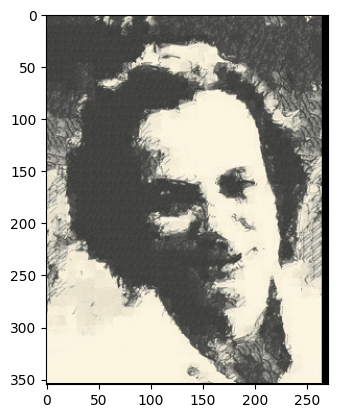

In [61]:
texture_img = cv2.imread('samples/sketch.tiff')
texture_img = cv2.cvtColor(texture_img, cv2.COLOR_BGR2RGB)
guidance_img = cv2.imread('samples/feynman.tiff')
guidance_img = cv2.cvtColor(guidance_img, cv2.COLOR_BGR2RGB)

patch_size = 12#25
overlap = 3#10
tol = 3
alpha = 0.5
num_iters = 3

result_iter = iterative_texture_transfer(texture_img, patch_size, overlap, tol,
                                         guidance_img, alpha,
                                         num_iters=num_iters)

plt.imshow(result_iter)
plt.show()


(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [62]:
# Helper function for patch selection
def choose_sample(cost, tol):
    """
    Choose a patch position based on SSD cost, handling edge cases.

    Args:
        cost: numpy.ndarray, SSD cost for each possible patch
        tol: float, tolerance for patch selection

    Returns:
        tuple, (y, x) coordinates of the chosen patch
    """
    flat_cost = cost.flatten()
    valid_indices = np.where(np.isfinite(flat_cost))[0]  # Filter out NaNs/infs
    if len(valid_indices) == 0:
        raise ValueError("No valid patches available to choose from.")
    sorted_indices = valid_indices[np.argsort(flat_cost[valid_indices])]
    max_idx = min(int(tol * len(sorted_indices)), len(sorted_indices) - 1)
    if max_idx < 0:
        raise ValueError("Tolerance too high or no patches available.")
    selected_idx = sorted_indices[random.randint(0, max_idx)]
    y = selected_idx // cost.shape[1]
    x = selected_idx % cost.shape[1]
    return y, x

# Laplacian Pyramid Blending Functions
def build_gaussian_pyramid(im, max_levels):
    pyramid = [im.astype(np.float32)]
    for _ in range(max_levels - 1):
        im = cv2.pyrDown(im)
        pyramid.append(im.astype(np.float32))
    return pyramid

def build_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        upsampled = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=size)
        laplacian = gaussian_pyramid[i] - upsampled
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

def reconstruct_from_laplacian(laplacian_pyramid):
    im = laplacian_pyramid[-1]
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        size = (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0])
        im = cv2.pyrUp(im, dstsize=size) + laplacian_pyramid[i]
    return im

def laplacian_pyramid_blending(image_A, image_B, mask, max_levels):
    GP_mask = build_gaussian_pyramid(mask, max_levels)
    GP_A = build_gaussian_pyramid(image_A, max_levels)
    LP_A = build_laplacian_pyramid(GP_A)
    GP_B = build_gaussian_pyramid(image_B, max_levels)
    LP_B = build_laplacian_pyramid(GP_B)

    blended_LP = []
    for i in range(max_levels):
        mask_level = GP_mask[i][..., np.newaxis] if len(GP_mask[i].shape) == 2 else GP_mask[i]
        blended_level = mask_level * LP_B[i] + (1 - mask_level) * LP_A[i]
        blended_LP.append(blended_level)

    blended_im = reconstruct_from_laplacian(blended_LP)
    return np.clip(blended_im, 0, 255).astype(np.uint8)

# New Feathered Mask Function
def create_feathered_mask(shape, x1, y1, x2, y2):
    """
    Create a feathered mask using distance transform for smooth blending.

    Args:
        shape: tuple, (height, width) of the image
        x1, y1, x2, y2: int, coordinates of the rectangular region

    Returns:
        numpy.ndarray, feathered mask with values from 0 to 1
    """
    mask = np.zeros(shape, dtype=np.float32)
    mask[y1:y2, x1:x2] = 1
    mask_binary = (mask * 255).astype(np.uint8)
    dist = cv2.distanceTransform(mask_binary, cv2.DIST_L2, 3)
    max_dist = np.max(dist)
    feathered_mask = dist / max_dist
    return feathered_mask

# Main Function with Modifications
def create_face_in_toast(toast_path, face_path):
    # Load images
    toast_im = cv2.imread(toast_path)
    face_im = cv2.imread(face_path)

    if toast_im is None or face_im is None:
        raise ValueError("Failed to load one or both images.")
    if toast_im.shape[0] < 20 or toast_im.shape[1] < 20:
        raise ValueError("Toast image is too small for patch_size=20.")

    # Define the region in the toast for the face
    x1, y1 = 63, 41
    x2, y2 = 241, 198

    # Resize the face to fit the region
    face_resized = cv2.resize(face_im, (x2 - x1, y2 - y1))

    # Perform texture transfer with adjusted parameters
    try:
        transferred_patch = texture_transfer(
            sample=toast_im,
            patch_size=7,  # Small patches for detail
            overlap=3,      # Increased for smoother transitions
            tol=0.1,        # Decreased for better patch matching
            guidance_im=face_resized,
            alpha=0.7      # Balanced weight between face and toast
        )
    except ValueError as e:
        print(f"Texture transfer failed: {e}")
        return None

    # Prepare images for blending
    image_A = toast_im.copy()
    image_B = toast_im.copy()
    image_B[y1:y2, x1:x2] = transferred_patch

    # Create a feathered mask for blending
    mask = create_feathered_mask(toast_im.shape[:2], x1, y1, x2, y2)

    # Perform Laplacian pyramid blending with more levels
    final_im = laplacian_pyramid_blending(image_A, image_B, mask, max_levels=8)

    # Save and return the result
    cv2.imwrite('face_in_toast.png', final_im)
    return final_im

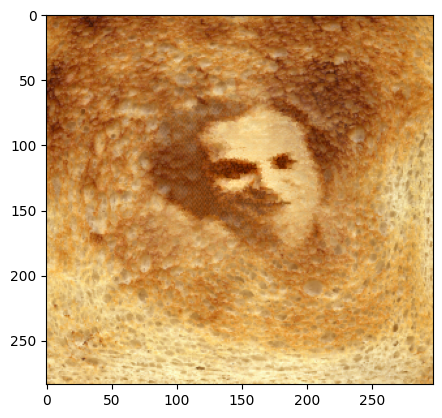

In [63]:
toast_path = 'samples/toast.png'
face_path = 'samples/feynman.tiff'
final_toast_face = create_face_in_toast(toast_path, face_path)

if final_toast_face is not None:
    plt.imshow(cv2.cvtColor(final_toast_face, cv2.COLOR_BGR2RGB))
    plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).

In [64]:
def compute_confidence(mask, patch_size):
    """
    Compute confidence term: ratio of known pixels in a patch centered at each pixel.

    Args:
        mask: Binary mask (0 for hole, 1 for known)
        patch_size: Size of the square patch

    Returns:
        Confidence map (same size as mask)
    """
    confidence = np.ones_like(mask, dtype=float)  # Known pixels start with 1
    confidence[mask == 0] = 0  # Hole pixels start with 0

    half_patch = patch_size // 2
    padded_mask = np.pad(mask, half_patch, mode='constant', constant_values=1)
    confidence_result = np.zeros_like(mask, dtype=float)

    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] == 0:  # Compute for hole pixels
                patch = padded_mask[y:y + patch_size, x:x + patch_size]
                confidence_result[y, x] = np.sum(patch) / (patch_size ** 2)

    return confidence_result

def compute_edge_strength(image, mask, patch_size):
    """
    Compute data term: gradient strength to prioritize structural regions.

    Args:
        image: Input image (grayscale or RGB)
        mask: Binary mask
        patch_size: Size of the square patch

    Returns:
        Data term map (same size as mask)
    """
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Compute gradients
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(grad_x ** 2 + grad_y ** 2)

    # Normalize gradient magnitude
    grad_mag = grad_mag / (np.max(grad_mag) + 1e-6)

    edge_strength = np.zeros_like(mask, dtype=float)
    half_patch = patch_size // 2
    padded_grad = np.pad(grad_mag, half_patch, mode='constant', constant_values=0)

    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] == 0:  # Compute for hole pixels
                patch_grad = padded_grad[y:y + patch_size, x:x + patch_size]
                edge_strength[y, x] = np.max(patch_grad)  # Max gradient in patch

    return edge_strength

def get_frontier(mask):
    """
    Identify boundary pixels of the hole (frontier).

    Args:
        mask: Binary mask

    Returns:
        Frontier map (1 for frontier pixels, 0 elsewhere)
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(mask, kernel, iterations=1)
    frontier = dilated - mask
    return frontier

def find_best_patch(image, target_patch, target_mask, patch_size, search_area):
    """
    Find the best matching patch from known regions using SSD.

    Args:
        image: Input image (RGB, shape: (height, width, 3))
        target_patch: Patch to be filled (shape: (patch_size, patch_size, 3))
        target_mask: Mask of the target patch (0 for hole, 1 for known, shape: (patch_size, patch_size))
        patch_size: Size of the patch (e.g., 9)
        search_area: Tuple (y_min, y_max, x_min, x_max) defining search region

    Returns:
        Best patch and its SSD value
    """
    h, w = image.shape[:2]
    half_patch = patch_size // 2
    best_ssd = float('inf')
    best_patch = None

    y_min, y_max, x_min, x_max = search_area
    y_min = max(0, y_min - half_patch)
    y_max = min(h - patch_size, y_max + half_patch)
    x_min = max(0, x_min - half_patch)
    x_max = min(w - patch_size, x_max + half_patch)

    for y in range(y_min, y_max):
        for x in range(x_min, x_max):
            candidate_patch = image[y:y + patch_size, x:x + patch_size]
            candidate_mask = mask[y:y + patch_size, x:x + patch_size]  # Assuming 'mask' is defined elsewhere

            # Skip if candidate contains hole pixels
            if np.any(candidate_mask == 0):
                continue

            # Compute SSD on known pixels
            diff = target_patch - candidate_patch
            valid_mask = target_mask == 1  # Shape: (9,9)
            if np.sum(valid_mask) == 0:
                continue

            # Fix broadcasting by expanding valid_mask to (9,9,1)
            valid_mask_expanded = np.expand_dims(valid_mask, axis=2)  # Shape: (9,9,1)
            ssd = np.sum((diff ** 2) * valid_mask_expanded) / np.sum(valid_mask)

            if ssd < best_ssd:
                best_ssd = ssd
                best_patch = candidate_patch.copy()

    return best_patch, best_ssd

def blend_patch(image, patch, y_start, x_start, patch_mask):
    """
    Blend the patch into the image (simple overwrite; seam-finding optional).

    Args:
        image: Input image
        patch: Selected patch
        y_start, x_start: Top-left coordinates of the patch region
        patch_mask: Mask of the patch region
    """
    patch_h, patch_w = patch.shape[:2]
    region = image[y_start:y_start + patch_h, x_start:x_start + patch_w]
    region[patch_mask == 0] = patch[patch_mask == 0]  # Overwrite hole pixels
    image[y_start:y_start + patch_h, x_start:x_start + patch_w] = region

def fill_hole(image, mask, patch_size=9):
    """
    Fill arbitrary-shaped holes using patch-based synthesis with priority.

    Args:
        image: Input image (RGB or grayscale)
        mask: Binary mask (0 for hole, 1 for known)
        patch_size: Size of the square patch

    Returns:
        Image with holes filled
    """
    working_image = image.copy()
    working_mask = mask.copy()  # 0 for hole, 1 for known

    confidence = compute_confidence(working_mask, patch_size)
    edge_strength = compute_edge_strength(working_image, working_mask, patch_size)

    while np.any(working_mask == 0):
        frontier = get_frontier(working_mask)
        if np.sum(frontier) == 0:  # No frontier pixels left
            break

        # Compute priority
        priority = confidence * edge_strength
        priority[frontier == 0] = -1  # Ignore non-frontier pixels

        # Find highest-priority pixel
        y, x = np.unravel_index(np.argmax(priority), priority.shape)

        # Define patch region
        half_patch = patch_size // 2
        patch_y_start = max(y - half_patch, 0)
        patch_y_end = min(y + half_patch + 1, working_image.shape[0])
        patch_x_start = max(x - half_patch, 0)
        patch_x_end = min(x + half_patch + 1, working_image.shape[1])

        patch_h = patch_y_end - patch_y_start
        patch_w = patch_x_end - patch_x_start

        target_patch = working_image[patch_y_start:patch_y_end, patch_x_start:patch_x_end]
        target_mask = working_mask[patch_y_start:patch_y_end, patch_x_start:patch_x_end]

        # Define search area (e.g., 50 pixels around target)
        search_area = (max(0, y - 50), min(working_image.shape[0], y + 50),
                       max(0, x - 50), min(working_image.shape[1], x + 50))

        # Find best patch
        best_patch, best_ssd = find_best_patch(working_image, target_patch, target_mask, patch_h, search_area)

        if best_patch is None:
            continue  # Skip if no valid patch found

        # Blend patch
        blend_patch(working_image, best_patch, patch_y_start, patch_x_start, target_mask)

        # Update mask and confidence
        working_mask[patch_y_start:patch_y_end, patch_x_start:patch_x_end][target_mask == 0] = 1
        confidence[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = 1.0

        # Recompute data term
        edge_strength = compute_edge_strength(working_image, working_mask, patch_size)

    return working_image

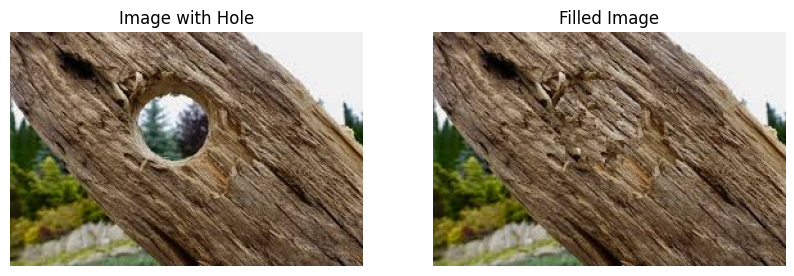

True

In [65]:
# Load the image
image = cv2.imread('samples/hole.jfif')
if image is None:
    print("Error: Could not load image.")
    exit()

# Create a synthetic arbitrary-shaped hole for demonstration
h, w = image.shape[:2]
mask = np.ones((h, w), dtype=np.uint8)
# Simulate an irregular hole centered at (h//2, w//2), ~50x50 pixels
cv2.circle(mask, (128, 73), 36, 0, -1)  # Circular base
# cv2.rectangle(mask, (w//2 - 20, h//2 - 30), (w//2 + 30, h//2 + 20), 0, -1)  # Overlap with rectangle

# Fill the hole
patch_size = 10
filled_image = fill_hole(image, mask, patch_size=patch_size)

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(image * mask[..., np.newaxis], cv2.COLOR_BGR2RGB))
plt.title("Image with Hole")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(filled_image, cv2.COLOR_BGR2RGB))
plt.title("Filled Image")
plt.axis('off')

plt.show()

# Save the result
cv2.imwrite('filled_toast.png', filled_image)